# Integrando Estocásticamente

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy.engine import create_engine
from scipy import stats
from numpy import random as nrandom
from ipywidgets import interact, IntSlider

%config InlineBackend.figure_format = "retina"

$$
    I = \int_0^1 \exp\left(-\frac{1}{2}x^2\right) dx = \sqrt{\frac{\pi}{2}} \text{erf}\left(\frac{1}{\sqrt{2}}\right)
$$

```
I ≈ 0.855624391
```

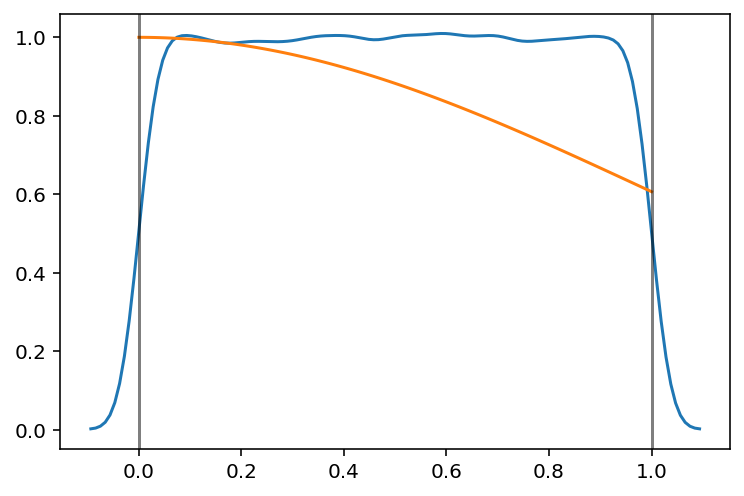

In [2]:
def h(x): return np.exp(-x ** 2 / 2)

xrange = np.linspace(0, 1, 100)
x = nrandom.uniform(low=0, high=1, size=90_000)
sns.kdeplot(x);
plt.plot(xrange, h(xrange))
plt.axvline(x=0, c="black", alpha=0.5)
plt.axvline(x=1, c="black", alpha=0.5)

In [3]:
h(x).mean()

0.8554964155912849

<h2 style="color:crimson">Ejercicio</h2>

Calcula la siguiente integral
$$
    I = \frac{1}{\sqrt{2\pi}}\int_{-\infty}^0 \exp\left(-\frac{1}{2}x^2\right) dx
$$

Considera:
$$
\begin{align}
    I &= \frac{1}{\sqrt{2\pi}}\int_{-\infty}^z \exp\left(-\frac{1}{2}x^2\right) dx \\
      &= \int_\mathbb{R} \mathbb{1}_{x < z}(x) \cdot \frac{1}{\sqrt{2\pi}}\exp\left(-\frac{1}{2}x^2\right) dx \\
      &= \int_\mathbb{R} h(x) p(x) dx
\end{align}
$$

---

## Estimando Diferencias en probabilidades

In [4]:
# desconocido 
p1, p2 = 0.8, 0.2 
# conocido
n, m = 10, 5
N = 10_000


nrandom.seed(314)
nobs = 200
D1 = nrandom.binomial(n, p1, size=nobs)
D2 = nrandom.binomial(m, p2, size=nobs)
@interact(obs=IntSlider(min=0, max=200, step=10, value=1))
def plot_posterior(obs):
    # Declaramos las dos distribuciones (no las conocemos)
    X = D1[:obs]
    Y = D2[:obs]
    
    # Muestras de la primera distribución posteriori
    P1 = nrandom.beta(X.sum() + 1, n * obs - X.sum() + 1, size=N)
    # Muestras de la segunda distribución posteriori
    P2 = nrandom.beta(Y.sum() + 1, m * obs - Y.sum() + 1, size=N)
    delta = P1 - P2
    
    p025 = np.quantile(delta, 0.025)
    p975 = np.quantile(delta, 0.975)
    
    sns.distplot(delta)
    title = f"95th interval = ({p025:0.2f}, {p975:0.2f})"
    title += f"\n mean = {delta.mean():0.3f}"
    plt.title(title, fontsize=13)
    plt.xlim(0.45, 0.65)

interactive(children=(IntSlider(value=1, description='obs', max=200, step=10), Output()), _dom_classes=('widge…

## MCMC
### Metropolis-Hastings

* Elegimos $x_0$ arbitrariamente
* Dado $x_i$, generamos $x_{i+1}$ de la siguiente manera:
    * Genera una muestra $y\sim \mathcal{N}(x_i, b^2)$
    * Evalua $r$ tal que
      $$
        r(x, y) = \min\left\{\frac{f(y)}{f(x)}, 1\right\}
      $$
    * Genera $u\sim U(0, 1)$, $$
        x_{i+1} = \begin{cases}
        y & \text{si }u < r \\
        x_i & \text{si }u > r \\
        \end{cases}
        $$
        
La secuencia $x_0, x_1, \ldots$ genera una cadena de Markov cuya distribución estacionaria es $f$

In [5]:
nrandom.seed(1643)
mu1, sigma, nobs = 2, 1, 100
samples = nrandom.normal(loc=mu1, scale=sigma, size=nobs)

In [6]:
mu_0 = 1
r_hist = []
hist = [mu_0]
b = 1

for _ in range(8_000):
    mu_hat = nrandom.normal(loc=mu_0, scale=b)
    
    L_1 = stats.norm(loc=mu_0, scale=sigma).logpdf(samples).sum()
    prior_1 =  stats.norm(loc=0, scale=10).logpdf(mu_0)
    
    L_hat = stats.norm(loc=mu_hat, scale=sigma).logpdf(samples).sum()
    prior_hat =  stats.norm(loc=0, scale=10).logpdf(mu_hat)
    
    p_1 = L_1 + prior_1
    p_hat = L_hat + prior_hat
    
    r = np.minimum(np.exp(p_hat - p_1), 1)
    # mu_0 = nrandom.choice([mu_hat, mu_0], p=[r, 1 - r])
    u = nrandom.uniform()
    mu_0 = mu_hat if u < r else mu_0
    
    r_hist.append(r)
    hist.append(mu_0)

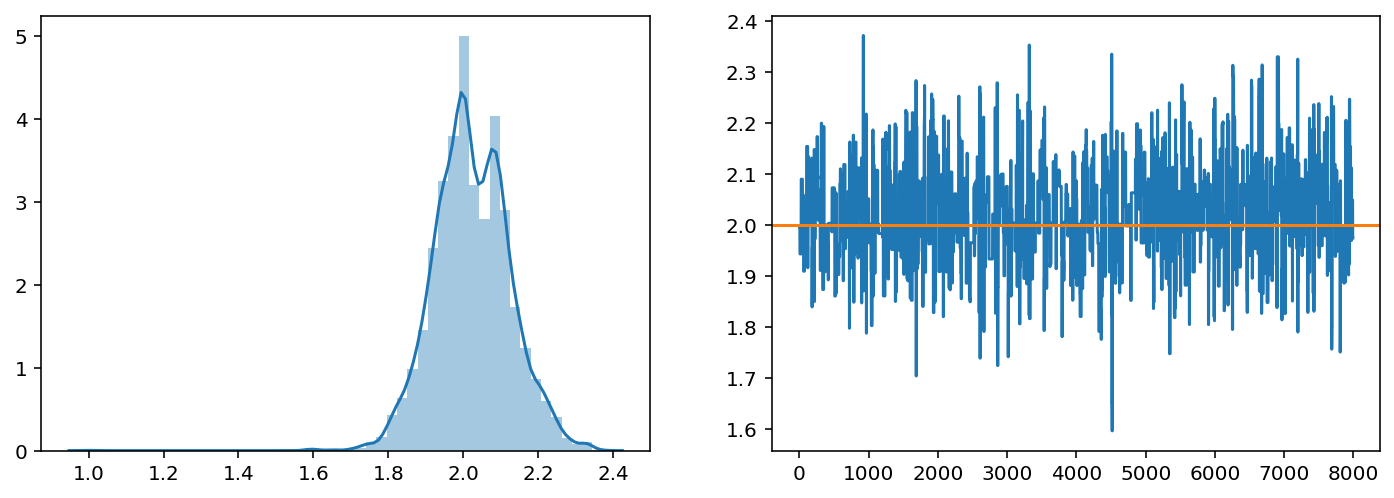

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.distplot(hist, ax=ax[0])
ax[1].plot(np.array(hist)[10:])
ax[1].axhline(y=mu1, c="tab:orange")

## Referencias

1. https://en.wikipedia.org/wiki/Conjugate_prior
2. https://docs.pymc.io/Probability_Distributions.html
3. 